# <span style="color:blue">Klasični pristup klasifikaciji slika limfnih čvorova</span>

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import h5py

from sklearn import preprocessing, model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from xgboost import XGBClassifier

### Učitavanje podataka iz hdf5 fajlova

In [2]:
hdf5_x_file = 'dataset/camelyonpatch_x.h5'
hdf5_y_file = 'dataset/camelyonpatch_y.h5'

hfx = h5py.File(hdf5_x_file, 'r')
hfy = h5py.File(hdf5_y_file, 'r')

X = hfx['x']
y = hfy['y']

print("X shape = ",X.shape)
print("y shape = ",y.shape)

X shape =  (32768, 96, 96, 3)
y shape =  (32768, 1, 1, 1)


In [3]:
X[:5]

array([[[[247, 246, 244],
         [246, 245, 243],
         [246, 245, 243],
         ...,
         [235, 236, 230],
         [251, 250, 248],
         [254, 254, 254]],

        [[247, 246, 244],
         [246, 245, 243],
         [246, 245, 243],
         ...,
         [247, 246, 244],
         [245, 243, 244],
         [245, 245, 247]],

        [[247, 246, 244],
         [246, 245, 243],
         [246, 245, 243],
         ...,
         [255, 254, 255],
         [243, 241, 244],
         [236, 235, 240]],

        ...,

        [[244, 244, 242],
         [244, 244, 242],
         [244, 244, 242],
         ...,
         [244, 242, 243],
         [245, 243, 244],
         [249, 245, 246]],

        [[243, 243, 241],
         [243, 243, 241],
         [244, 244, 242],
         ...,
         [242, 242, 242],
         [243, 241, 242],
         [245, 243, 244]],

        [[243, 243, 241],
         [243, 243, 241],
         [244, 244, 242],
         ...,
         [243, 243, 243],
        

In [4]:
y[:5]

array([[[[0]]],


       [[[1]]],


       [[[0]]],


       [[[1]]],


       [[[1]]]], dtype=uint8)

### Konvertovanje u np.array

In [5]:
X = np.array(X)[:12000]
y = np.array(y)[:12000]

In [6]:
#Reshape iz  4D u 2D

nsamples, nx, ny, nrgb = X.shape
X = X.reshape((nsamples,nx*ny*nrgb))
print('2D X shape = ',X.shape)

y = y.ravel()
print('2D y shape = ',y.shape)

2D X shape =  (12000, 27648)
2D y shape =  (12000,)


In [7]:
#Provera koliko u datasetu ima benignih i malignih uzoraka

benigni = np.sum(y==1)
print('Broj pozitivnih instanci dataseta: ', benigni)

maligni = np.sum(y==0)
print('Broj negativnih instanci dataseta: ', maligni)

Broj pozitivnih instanci dataseta:  5997
Broj negativnih instanci dataseta:  6003


### Podela dataseta na Training, Test i Validation set

In [8]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y, test_size = 0.4, random_state = 42, stratify = y )
X_test, X_validation, y_test, y_validation = train_test_split(X_test_and_val, y_test_and_val, test_size = 0.5, random_state = 42, stratify = y_test_and_val )

In [9]:
print(X_train)

[[ 55  29  40 ...  66  19  71]
 [ 69  32  66 ... 166 128 175]
 [201 206 212 ... 224  97 212]
 ...
 [201 157 192 ... 255 217 239]
 [ 40  23  57 ... 231 169 206]
 [228 222 236 ... 226 215 231]]


In [10]:
print(y_train)

[0 0 1 ... 0 1 0]


In [11]:
print(X_test)

[[142  95 129 ... 202 130 152]
 [148 126 173 ... 159 111 153]
 [233 226 234 ... 229 222 230]
 ...
 [208 117 150 ... 234 239 233]
 [244 207 225 ... 246 246 244]
 [ 82  22  84 ... 107  58 103]]


In [12]:
print(y_test)

[1 0 0 ... 0 0 0]


In [13]:
print(X_validation)

[[218 228 227 ... 110  85 186]
 [244 233 231 ... 236 205 211]
 [175 128 146 ... 207 184 194]
 ...
 [147  77 175 ... 108  44 158]
 [153  96 128 ... 201 130 164]
 [252 246 255 ...  52  30  76]]


In [14]:
print(y_validation)

[1 1 1 ... 0 1 0]


In [15]:
print("Trening set (shape): ",X_train.shape)
print("Test set (shape): ",X_test.shape)
print("Validation set (shape): ",X_validation.shape)

Trening set (shape):  (7200, 27648)
Test set (shape):  (2400, 27648)
Validation set (shape):  (2400, 27648)


In [16]:
#Zbog velike količine iskorišćene memorije, oslobadja se deo koji nije više neophodan. 
#Nakon podele na train i test, mogu X i y da se uklone
del X, y

### Provera stratifikovanosti podataka za Training, Test i Validation set

In [17]:
benigni_train = np.sum(y_train==1)
print('Broj pozitivnih instanci trening seta: ', benigni_train)

maligni_train = np.sum(y_train==0)
print('Broj negativnih instanci trening seta: ', maligni_train)

Broj pozitivnih instanci trening seta:  3598
Broj negativnih instanci trening seta:  3602


In [18]:
benigni_test = np.sum(y_test==1)
print('Broj pozitivnih instanci test seta: ', benigni_test)
maligni_test = np.sum(y_test==0)
print('Broj negativnih instanci test seta: ', maligni_test)

Broj pozitivnih instanci test seta:  1200
Broj negativnih instanci test seta:  1200


In [19]:
benigni_val = np.sum(y_validation==1)
print('Broj pozitivnih instanci validacionog seta: ', benigni_val)
maligni_val = np.sum(y_validation==0)
print('Broj negativnih instanci validacionog seta: ', maligni_val)

Broj pozitivnih instanci validacionog seta:  1199
Broj negativnih instanci validacionog seta:  1201


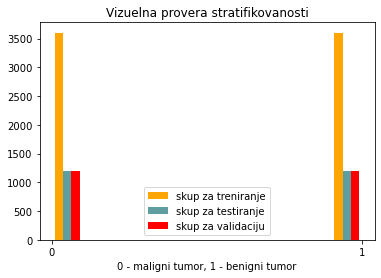

In [20]:
plt.title('Vizuelna provera stratifikovanosti')
plt.xticks([0,1])
plt.xlabel('0 - maligni tumor, 1 - benigni tumor')
plt.hist([y_train, y_test, y_validation], color=['orange', 'cadetblue', 'red'], label=['skup za treniranje', 'skup za testiranje', 'skup za validaciju'])
plt.legend(loc='best')
plt.show()

### Standardizacija

In [21]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

In [22]:
print(X_train)

[[-1.88647399 -1.44093522 -2.593453   ... -1.744461   -1.58952023
  -2.00642359]
 [-1.66148322 -1.39940955 -2.09924623 ... -0.14662173 -0.10030922
  -0.06609754]
 [ 0.45985838  1.00907972  0.67591488 ...  0.78012505 -0.52384629
   0.62421077]
 ...
 [ 0.45985838  0.33082699  0.29575583 ...  1.27545522  1.11565207
   1.12794926]
 [-2.12753554 -1.52398658 -2.2703178  ...  0.8919738   0.45985272
   0.51226888]
 [ 0.89376916  1.23055     1.13210575 ...  0.81208184  1.0883271
   0.97869341]]


In [23]:
print(X_test)

[[-0.48831703 -0.52737033 -0.9017452  ...  0.42860041 -0.07298424
  -0.49520811]
 [-0.39189241 -0.09827167 -0.06539528 ... -0.25847047 -0.33257148
  -0.47655113]
 [ 0.97412301  1.28591757  1.09408984 ...  0.86001701  1.1839645
   0.96003643]
 ...
 [ 0.57235376 -0.2228487  -0.50257819 ...  0.93990898  1.41622677
   1.01600737]
 [ 1.15090147  1.02292161  0.92301827 ...  1.13164969  1.51186417
   1.22123417]
 [-1.45256321 -1.53782847 -1.75710308 ... -1.08934689 -1.05668326
  -1.40940019]]


In [24]:
print(X_validation)

[[ 0.73306146  1.31360135  0.96103417 ... -1.04141172 -0.68779613
   0.13912925]
 [ 1.15090147  1.38281081  1.03706599 ...  0.97186576  0.95170223
   0.60555379]
 [ 0.04201837 -0.07058788 -0.57861    ...  0.50849237  0.66479002
   0.2883851 ]
 ...
 [-0.40796318 -0.77652439 -0.02737937 ... -1.0733685  -1.24795807
  -0.38326622]
 [-0.31153857 -0.51352844 -0.92075315 ...  0.41262202 -0.07298424
  -0.27132433]
 [ 1.27946763  1.56275541  1.49325685 ... -1.96815849 -1.43923288
  -1.91313868]]


# <span style="color:blue">1. Logistička regresija</span>

In [25]:
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)

C:\Users\nikolap\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=0)

### Predikcija na test setu

In [26]:
y_pred_lr = lr.predict(X_test)
print(y_pred_lr)

[0 1 0 ... 0 0 1]


In [27]:
lr_acc = accuracy_score(y_pred_lr,y_test)
print('Tačnost: {0:.2f}%'.format(lr_acc*100))

Tačnost: 65.33%


In [28]:
lr_cr = classification_report(y_pred_lr,y_test)
print(lr_cr)

              precision    recall  f1-score   support

           0       0.63      0.66      0.65      1150
           1       0.67      0.65      0.66      1250

    accuracy                           0.65      2400
   macro avg       0.65      0.65      0.65      2400
weighted avg       0.65      0.65      0.65      2400



In [29]:
lr_cm = confusion_matrix(y_pred_lr,y_test)
lr_cm

array([[759, 391],
       [441, 809]], dtype=int64)

### Predikcija na trening setu

In [30]:
y_pred_train_lr = lr.predict(X_train)
print(y_pred_train_lr)

[0 0 1 ... 0 1 0]


In [31]:
lr_train_acc = accuracy_score(y_pred_train_lr,y_train)
print('Tačnost: {0:.2f}%'.format(lr_train_acc*100))

Tačnost: 99.97%


In [32]:
lr_train_cr = classification_report(y_pred_train_lr, y_train)
print(lr_train_cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3602
           1       1.00      1.00      1.00      3598

    accuracy                           1.00      7200
   macro avg       1.00      1.00      1.00      7200
weighted avg       1.00      1.00      1.00      7200



In [33]:
lr_train_cm = confusion_matrix(y_pred_train_lr,y_train)
lr_train_cm

array([[3601,    1],
       [   1, 3597]], dtype=int64)

### Provera preprilagodjavanja

In [34]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(lr_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(lr_acc*100))

Tačnost na skupu za treniranje: 99.97%
Tačnost na skupu za testiranje: 65.33%


Primena modela na validacioni set, zbog preprilagodjavanja trening seta, da se vidi da li validacioni set mnogo odstupa od test testa.

In [134]:
y_pred_val_lr = lr.predict(X_validation)
print(y_pred_val_lr)

[1 1 1 ... 1 1 1]


In [135]:
lr_val_acc = accuracy_score(y_pred_val_lr,y_validation)
print('Tačnost: {0:.2f}%'.format(lr_val_acc*100))

Tačnost: 64.75%


# <span style="color:blue">2. Slučajne šume</span>

In [35]:
rfc = RandomForestClassifier(n_estimators = 20, max_depth = 3, random_state = 7)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=20, random_state=7)

### Predikcija na test setu

In [36]:
y_pred_rfc = rfc.predict(X_test)
print(y_pred_rfc)

[1 1 0 ... 1 0 0]


In [37]:
rfc_acc = accuracy_score(y_pred_rfc,y_test)
print('Tačnost: {0:.2f}%'.format(rfc_acc*100))

Tačnost: 72.00%


Uz podrazumevan poziv RandomForestClassifier metode dobijamo tačnost **78.35%**, ali ujedno preprilagodjen model koji ima tačnost **1** na predikciji trening seta.

In [38]:
rfc_cr = classification_report(y_pred_rfc,y_test)
print(rfc_cr)

              precision    recall  f1-score   support

           0       0.58      0.81      0.67       862
           1       0.86      0.67      0.75      1538

    accuracy                           0.72      2400
   macro avg       0.72      0.74      0.71      2400
weighted avg       0.76      0.72      0.73      2400



In [39]:
rfc_cm = confusion_matrix(y_pred_rfc,y_test)
rfc_cm

array([[ 695,  167],
       [ 505, 1033]], dtype=int64)

### Predikcija na trening setu

In [40]:
y_pred_train_rfc = rfc.predict(X_train)
print(y_pred_train_rfc)

[0 0 1 ... 0 0 0]


In [41]:
rfc_train_acc = accuracy_score(y_pred_train_rfc, y_train)
print('Tačnost: {0:.2f}%'.format(rfc_train_acc*100))

Tačnost: 74.18%


In [42]:
rfc_train_cr = classification_report(y_pred_train_rfc, y_train)
print(rfc_train_cr)

              precision    recall  f1-score   support

           0       0.60      0.84      0.70      2583
           1       0.88      0.69      0.77      4617

    accuracy                           0.74      7200
   macro avg       0.74      0.76      0.74      7200
weighted avg       0.78      0.74      0.75      7200



In [43]:
rfc_train_cm = confusion_matrix(y_pred_train_rfc, y_train)
rfc_train_cm

array([[2163,  420],
       [1439, 3178]], dtype=int64)

### Provera preprilagodjavanja

In [44]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(rfc_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(rfc_acc*100))

Tačnost na skupu za treniranje: 74.18%
Tačnost na skupu za testiranje: 72.00%


# <span style="color:blue">3. Model k-najbližih suseda</span>

### Provera najboljeg mogućeg koeficijenta k
Za vrednosti od 1 do 10 proveravamo koja bi vrednost koeficijenta k bila najbolja

In [45]:
k_range = list(range(1, 10))
scores = []
maks = 0
best_k = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)
    if acc > maks:
        maks = acc
        best_k = k

### Vizuelizacija odnosa preciznosti predikcije i vrednosti koeficijenta k

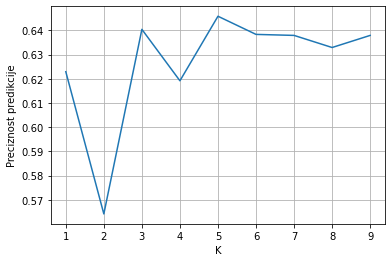

In [46]:
plt.xticks(np.linspace(0,10,11))
plt.xlabel('K')
plt.ylabel('Preciznost predikcije')
plt.grid()
plt.plot(k_range, scores)
plt.show()

### Predikcija na test setu

In [47]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [48]:
y_pred_knn = knn.predict(X_test)
print(y_pred_knn)

[0 0 0 ... 0 0 0]


In [49]:
knn_acc = accuracy_score(y_pred_knn,y_test)
print('Tačnost: {0:.2f}%'.format(knn_acc*100))

Tačnost: 64.58%


In [50]:
knn_cr = classification_report(y_pred_knn,y_test)
print(knn_cr)

              precision    recall  f1-score   support

           0       0.80      0.61      0.69      1576
           1       0.49      0.71      0.58       824

    accuracy                           0.65      2400
   macro avg       0.65      0.66      0.64      2400
weighted avg       0.69      0.65      0.65      2400



In [51]:
knn_cm = confusion_matrix(y_pred_knn,y_test)
knn_cm

array([[963, 613],
       [237, 587]], dtype=int64)

### Predikcija na trening setu

In [52]:
y_pred_train_knn = knn.predict(X_train)
print(y_pred_train_knn)

[0 0 1 ... 0 0 0]


In [53]:
knn_train_acc = accuracy_score(y_pred_train_knn, y_train)
print('Tačnost: {0:.2f}%'.format(knn_train_acc*100))

Tačnost: 74.50%


In [54]:
knn_train_cr = classification_report(y_pred_train_knn, y_train)
print(knn_train_cr)

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      4846
           1       0.57      0.87      0.69      2354

    accuracy                           0.74      7200
   macro avg       0.74      0.78      0.74      7200
weighted avg       0.80      0.74      0.75      7200



In [55]:
knn_train_cm = confusion_matrix(y_pred_train_knn, y_train)
knn_train_cm

array([[3306, 1540],
       [ 296, 2058]], dtype=int64)

### Provera preprilagodjavanja

In [56]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(knn_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(knn_acc*100))

Tačnost na skupu za treniranje: 74.50%
Tačnost na skupu za testiranje: 64.58%


# <span style="color:blue">5. Stabla odlučivanja</span>
## 5.1. criterion = 'Gini'

In [57]:
dtc = DecisionTreeClassifier(criterion = 'gini', max_features=0.9, max_depth=3, random_state=7)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, max_features=0.9, random_state=7)

### Predikcija na test setu

In [58]:
y_pred_dtc = dtc.predict(X_test)
print(y_pred_dtc)

[1 0 0 ... 1 0 1]


In [59]:
dtc_acc = accuracy_score(y_pred_dtc, y_test)
print('Tačnost: {0:.2f}%'.format(dtc_acc*100))

Tačnost: 65.29%


In [60]:
dtc_cr = classification_report(y_pred_dtc, y_test)
print(dtc_cr)

              precision    recall  f1-score   support

           0       0.49      0.72      0.59       819
           1       0.81      0.62      0.70      1581

    accuracy                           0.65      2400
   macro avg       0.65      0.67      0.64      2400
weighted avg       0.70      0.65      0.66      2400



In [61]:
dtc_cm = confusion_matrix(y_pred_dtc, y_test)
print(dtc_cm)

[[593 226]
 [607 974]]


### Predikcija na trening setu

In [62]:
y_pred_train_dtc = dtc.predict(X_train)
print(y_pred_train_dtc)

[1 1 1 ... 1 0 1]


In [63]:
dtc_train_acc = accuracy_score(y_pred_train_dtc, y_train)
print('Tačnost: {0:.2f}%'.format(dtc_train_acc*100))

Tačnost: 68.67%


In [64]:
dtc_train_cr = classification_report(y_pred_train_dtc, y_train)
print(dtc_train_cr)

              precision    recall  f1-score   support

           0       0.51      0.79      0.62      2358
           1       0.86      0.64      0.73      4842

    accuracy                           0.69      7200
   macro avg       0.69      0.71      0.68      7200
weighted avg       0.75      0.69      0.70      7200



In [65]:
dtc_train_cm = confusion_matrix(y_pred_train_dtc, y_train)
print(dtc_train_cm)

[[1852  506]
 [1750 3092]]


### Provera preprilagodjavanja

In [66]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(dtc_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(dtc_acc*100))

Tačnost na skupu za treniranje: 68.67%
Tačnost na skupu za testiranje: 65.29%


## 5.2 criterion = 'Enthropy'

In [67]:
dtc_e = DecisionTreeClassifier(criterion = 'entropy' , random_state=7)
dtc_e.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=7)

### Predikcija na test setu

In [68]:
y_pred_dtc_e = dtc.predict(X_test)
print(y_pred_dtc_e)

[1 0 0 ... 1 0 1]


In [69]:
dtc_e_acc = accuracy_score(y_pred_dtc_e, y_test)
print('Tačnost: {0:.2f}%'.format(dtc_e_acc*100))

Tačnost: 65.29%


In [70]:
dtc_e_cr = classification_report(y_pred_dtc_e, y_test)
print(dtc_e_cr)

              precision    recall  f1-score   support

           0       0.49      0.72      0.59       819
           1       0.81      0.62      0.70      1581

    accuracy                           0.65      2400
   macro avg       0.65      0.67      0.64      2400
weighted avg       0.70      0.65      0.66      2400



In [71]:
dtc_e_cm = confusion_matrix(y_pred_dtc_e, y_test)
print(dtc_e_cm)

[[593 226]
 [607 974]]


### Predikcija na trening setu

In [72]:
y_pred_train_dtc_e = dtc.predict(X_train)
print(y_pred_train_dtc_e)

[1 1 1 ... 1 0 1]


In [73]:
dtc_e_train_acc = accuracy_score(y_pred_train_dtc_e, y_train)
print('Tačnost: {0:.2f}%'.format(dtc_e_train_acc*100))

Tačnost: 68.67%


In [74]:
dtc_e_train_cr = classification_report(y_pred_train_dtc_e, y_train)
print(dtc_e_train_cr)

              precision    recall  f1-score   support

           0       0.51      0.79      0.62      2358
           1       0.86      0.64      0.73      4842

    accuracy                           0.69      7200
   macro avg       0.69      0.71      0.68      7200
weighted avg       0.75      0.69      0.70      7200



In [75]:
dtc_e_train_cm = confusion_matrix(y_pred_train_dtc_e, y_train)
print(dtc_e_train_cm)

[[1852  506]
 [1750 3092]]


### Provera preprilagodjavanja

In [76]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(dtc_e_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(dtc_e_acc*100))

Tačnost na skupu za treniranje: 68.67%
Tačnost na skupu za testiranje: 65.29%


Ne vidi se nikakva razlika izmedju postavljenih kriterijuma. Rezultati su isti

# <span style="color:blue">6. Naivni Bayes</span>

In [77]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

### Predikcija na test setu

In [78]:
y_pred_nb = nb.predict(X_test)
print(y_pred_nb)

[0 0 0 ... 0 0 0]


In [79]:
nb_acc = accuracy_score(y_pred_nb,y_test)
print('Tačnost: {0:.2f}%'.format(nb_acc*100))

Tačnost: 66.38%


In [80]:
nb_cr = classification_report(y_pred_nb,y_test)
print(nb_cr)

              precision    recall  f1-score   support

           0       0.59      0.69      0.64      1027
           1       0.74      0.64      0.69      1373

    accuracy                           0.66      2400
   macro avg       0.66      0.67      0.66      2400
weighted avg       0.67      0.66      0.67      2400



In [81]:
nb_cm = confusion_matrix(y_pred_nb,y_test)
print(nb_cm)

[[710 317]
 [490 883]]


### Predikcija na trening setu

In [82]:
y_pred_train_nb = nb.predict(X_train)
print(y_pred_train_nb)

[1 0 1 ... 0 1 0]


In [83]:
nb_train_acc = accuracy_score(y_pred_train_nb,y_train)
print('Tačnost: {0:.2f}%'.format(nb_train_acc*100))

Tačnost: 66.32%


In [84]:
nb_train_cr = classification_report(y_pred_train_nb,y_train)
print(nb_train_cr)

              precision    recall  f1-score   support

           0       0.57      0.70      0.63      2895
           1       0.76      0.64      0.69      4305

    accuracy                           0.66      7200
   macro avg       0.66      0.67      0.66      7200
weighted avg       0.68      0.66      0.67      7200



In [85]:
nb_train_cm = confusion_matrix(y_pred_train_nb,y_train)
print(nb_train_cm)

[[2036  859]
 [1566 2739]]


### Provera preprilagodjavanja

In [86]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(nb_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(nb_acc*100))

Tačnost na skupu za treniranje: 66.32%
Tačnost na skupu za testiranje: 66.38%


# <span style="color:blue">7. Metod potpornih vektora</span>

In [87]:
svc = SVC(kernel = 'rbf', random_state = 0)
svc.fit(X_train, y_train)

SVC(random_state=0)

### Predikcija na test setu

In [88]:
y_pred_svc = svc.predict(X_test)
print(y_pred_svc)

[1 0 0 ... 1 0 0]


In [89]:
svc_acc = accuracy_score(y_pred_svc, y_test)
print('Tačnost: {0:.2f}%'.format(svc_acc*100))

Tačnost: 80.25%


In [90]:
svc_cr = classification_report(y_pred_svc, y_test)
print(svc_cr)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1162
           1       0.82      0.79      0.81      1238

    accuracy                           0.80      2400
   macro avg       0.80      0.80      0.80      2400
weighted avg       0.80      0.80      0.80      2400



In [91]:
svc_cm = confusion_matrix(y_pred_svc, y_test)
print(svc_cm)

[[944 218]
 [256 982]]


### Predikcija na trening setu

In [129]:
y_pred_train_svc = svc.predict(X_train)
print(y_pred_train_svc)

[0 0 1 ... 0 1 0]


In [130]:
svc_train_acc = accuracy_score(y_pred_train_svc, y_train)
print('Tačnost: {0:.2f}%'.format(svc_train_acc*100))

Tačnost: 93.19%


In [132]:
svc_train_cr = classification_report(y_pred_train_svc, y_train)
print(svc_train_cr)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      3500
           1       0.95      0.92      0.93      3700

    accuracy                           0.93      7200
   macro avg       0.93      0.93      0.93      7200
weighted avg       0.93      0.93      0.93      7200



In [133]:
svc_train_cm = confusion_matrix(y_pred_train_svc, y_train)
print(svc_train_cm)

[[3306  194]
 [ 296 3404]]


### Provera preprilagodjavanja

In [136]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(svc_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(svc_acc*100))

Tačnost na skupu za treniranje: 93.19%
Tačnost na skupu za testiranje: 80.25%


### K-fold unakrsna validacija

In [92]:
accuracies = cross_val_score(estimator = svc, X = X_train, y = y_train, cv = 10)
print("Tačnost: ",accuracies.mean()*100)
print("Standardna devijacija: ",accuracies.std()*100)

Tačnost:  79.04166666666667
Standardna devijacija:  1.2194570994028244


Pošto je u startu dobijeno bolje rešenje, ne mora da se izvršava sledeći korak bi bio traženje boljih parametara pomoću Grid Search-a.
Zakomentarisan je kao prikaz mogućih narednih koraka traženja boljih parametara.

In [93]:
### Primena Grid Search-a za nalaženje najboljih parametara za SVC, radi dostizanja bolje tačnosti modela

# parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
#               {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.001, 0.01, 1, 10, 100, 1000]}]
# grid_search = GridSearchCV(estimator = svc,
#                            param_grid = parameters,
#                            scoring = 'accuracy',
#                            cv = 10,
#                            n_jobs = -1)
# grid_search.fit(X_train, y_train)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_
# print("Najbolja tačnost: ", best_accuracy*100)
# print("Najbolji parametri: ", best_parameters)

In [94]:
# if best_params['kernel'] == 'rbf':
#     svc = SVC(kernel = best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])
# else:
#     svc = SVC(kernel = best_params['kernel'], C=best_params['C'])
# svc.fit(X_validation, y_validation)

In [95]:
# y_pred_svc_val = svc.predict(X_validation)
# print(y_pred_svc_val)

In [96]:
# svc_val_cr = classification_report(y_pred_svc_val, y_validation)
# print(svc_val_cr)

In [97]:
# svc_val_cm = confusion_matrix(y_pred_svc_val, y_validation)
# print(svc_val_cm)

# <span style="color:blue">7. Pojačavanje</span>

## 7.1 AdaBoost

In [137]:
ab = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_features=0.9, max_depth=3, random_state=7))
ab.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         max_features=0.9,
                                                         random_state=7))

In [138]:
y_pred_ab = ab.predict(X_test)
print(y_pred_ab)

[1 0 0 ... 0 0 0]


In [139]:
ab_acc = accuracy_score(y_pred_ab, y_test)
print('Tačnost: {0:.2f}%'.format(ab_acc*100))

Tačnost: 73.00%


In [140]:
ab_cr = classification_report(y_pred_ab, y_test)
print(ab_cr)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1212
           1       0.72      0.73      0.73      1188

    accuracy                           0.73      2400
   macro avg       0.73      0.73      0.73      2400
weighted avg       0.73      0.73      0.73      2400



In [141]:
ab_cm = confusion_matrix(y_pred_ab, y_test)
print(ab_cm)

[[882 330]
 [318 870]]


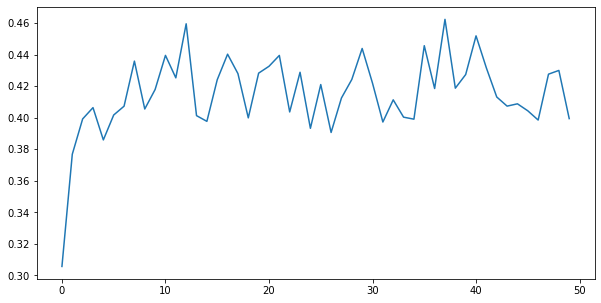

In [145]:
plt.figure(figsize = (10,5))
plt.plot(range(0, ab.n_estimators), ab.estimator_errors_)
plt.show()

## 7.2 XGBoost

In [192]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, y_train)

[21:06:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [193]:
y_pred_xgb = xgb.predict(X_test)
print(y_pred_xgb)

[1 1 0 ... 0 0 0]


In [194]:
xgb_acc = accuracy_score(y_pred_xgb, y_test)
print('Tačnost: {0:.2f}%'.format(xgb_acc*100))

Tačnost: 77.79%


In [195]:
xgb_cr = classification_report(y_pred_xgb, y_test)
print(xgb_cr)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1135
           1       0.81      0.76      0.78      1265

    accuracy                           0.78      2400
   macro avg       0.78      0.78      0.78      2400
weighted avg       0.78      0.78      0.78      2400



In [196]:
xgb_cm = confusion_matrix(y_pred_xgb, y_test)
print(xgb_cm)

[[901 234]
 [299 966]]


## 7.3 Gradient Boosting 

In [184]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
gb_acc = 0
gb_cm = 0
y_pred = 0
for learning_rate in lr_list:
    gb = GradientBoostingClassifier(n_estimators=30, learning_rate=learning_rate, max_features=2, max_depth=3, random_state=0)
    gb.fit(X_train, y_train)
    
    y_pred_gb = gb.predict(X_test)
    acc = gb.score(X_test, y_test)
    print("Learning rate: ", learning_rate)
    
    if gb_acc < acc:
        gb_acc = acc
        gb_cm = confusion_matrix(y_pred_gb, y_test)
        y_pred = y_pred_gb
    print("==============================")

Learning rate:  0.05
Learning rate:  0.075
Learning rate:  0.1
Learning rate:  0.25
Learning rate:  0.5
Learning rate:  0.75
Learning rate:  1


In [185]:
print('Tačnost: {0:.2f}%'.format(gb_acc*100))

Tačnost: 76.42%


In [186]:
gb_cr = classification_report(y_pred, y_test) 
print(gb_cr)

              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1118
           1       0.80      0.75      0.77      1282

    accuracy                           0.76      2400
   macro avg       0.76      0.77      0.76      2400
weighted avg       0.77      0.76      0.76      2400



In [187]:
print(gb_cm)

[[876 242]
 [324 958]]


# <span style="color:blue">8. Prosta agregacija</span>

In [197]:
bag = BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100, bootstrap=True, random_state=7)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, random_state=7)

In [198]:
y_pred_bag = bag.predict(X_test)
print(y_pred_bag)

[1 0 0 ... 1 0 0]


In [199]:
bag_acc = accuracy_score(y_pred_bag, y_test)
print('Tačnost: {0:.2f}%'.format(bag_acc*100))

Tačnost: 74.21%


In [200]:
bag_cr = classification_report(y_pred_bag, y_test)
print(bag_cr)

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      1157
           1       0.76      0.73      0.75      1243

    accuracy                           0.74      2400
   macro avg       0.74      0.74      0.74      2400
weighted avg       0.74      0.74      0.74      2400



In [201]:
bag_cm = confusion_matrix(y_pred_bag, y_test)
print(bag_cm)

[[869 288]
 [331 912]]


# <span style="color:blue"> Uporedjivanje</span>

In [205]:
accuracies = [lr_acc, rfc_acc, knn_acc, dtc_acc, nb_acc, svc_acc, ab_acc, xgb_acc, gb_acc, bag_acc]
confusion_matrices = [lr_cm, rfc_cm, knn_cm, dtc_cm, nb_cm, svc_cm, ab_cm, xgb_cm, gb_cm, bag_cm]
classification_reports = [lr_cr, rfc_cr, knn_cr, dtc_cr, nb_cr, svc_cr, ab_cr, xgb_cr, gb_cr, bag_cr]
labels = ["Logistička regresija", "Slučajne šume", "K najbližih suseda", "Stabla odlučivanja", "Naivni bayes", "Metod potpornih vektora", "AdaBoost", "XGBoost", "GradientBoost", "Prosta agregacija"]

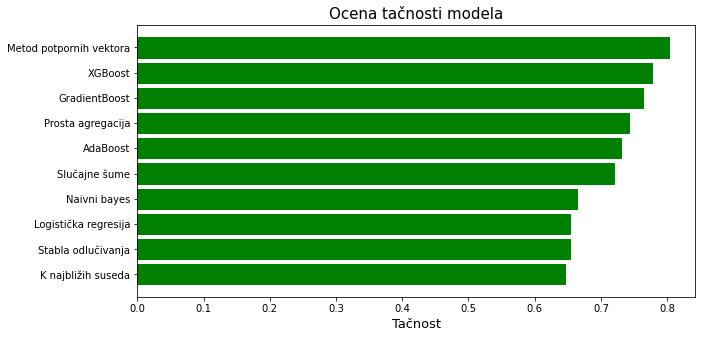

In [221]:
plt.figure(figsize = (10,5))

unsorted_list = [(labels, accuracies) for labels, accuracies in 
                  zip(accuracies, labels)]
sorted_list = sorted(unsorted_list) 

labels_sorted = []
accuracies_sorted = []

for i in sorted_list:
    labels_sorted += [i[1]]
    accuracies_sorted += [i[0]]
    
plt.title("Ocena tačnosti modela", fontsize=15)
plt.xlabel("Tačnost", fontsize=13)

plt.barh(labels_sorted, accuracies_sorted, color="green", edgecolor='green')

plt.show()